# Estimate noise level from data


#### Imports:

In [152]:
# imports
import numpy as np
import cuqi
import sys
import matplotlib.pyplot as plt
import matplotlib
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from advection_diffusion_inference_utils import parse_commandline_args,\
    read_data_files,\
    create_domain_geometry,\
    create_PDE_form,\
    create_prior_distribution,\
    create_exact_solution_and_data,\
    set_the_noise_std,\
    sample_the_posterior,\
    create_experiment_tag,\
    plot_experiment,\
    save_experiment_data,\
    Args,\
    build_grids,\
    create_time_steps,\
    plot_time_series

#### Read data for 10 cases (5 animals, 2 ears each) 

In [153]:
mice_list = ['m1', 'm2', 'm3', 'm4', 'm6']
ear_list = ['l', 'r']
args_list = [Args() for i in range(len(mice_list)*len(ear_list))]

times_list = [] 
locations_list = []
real_data_list = []
real_std_data_list = []
diff_locations_list = []
real_data_diff_list = []
real_std_data_diff_list = []
max_concentration = 0
min_concentration = 0


# product of mice and ear
cases_list = [(mice, ear) for mice in mice_list for ear in ear_list]

# loop over all cases
for i, case in enumerate(cases_list):
    # Set animal and ear
    args_list[i].animal = case[0]
    args_list[i].ear = case[1]
    args_list[i].num_ST = 4 # 4 is max 

    # read
    times, locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(args_list[i])

    # append
    times_list.append(times)
    locations_list.append(locations)
    real_data_list.append(real_data.reshape(len(locations), len(times)))
    real_std_data_list.append(real_std_data.reshape(len(locations), len(times)))
    diff_locations_list.append(diff_locations)
    real_data_diff_list.append(real_data_diff)
    real_std_data_diff_list.append(real_std_data_diff)

    # update max and min concentration
    max_concentration = max(max_concentration, np.max(real_data))
    min_concentration = min(min_concentration, np.min(real_data))



CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.
CA and ST data.


#### For illustration, plot data for the 10 cases

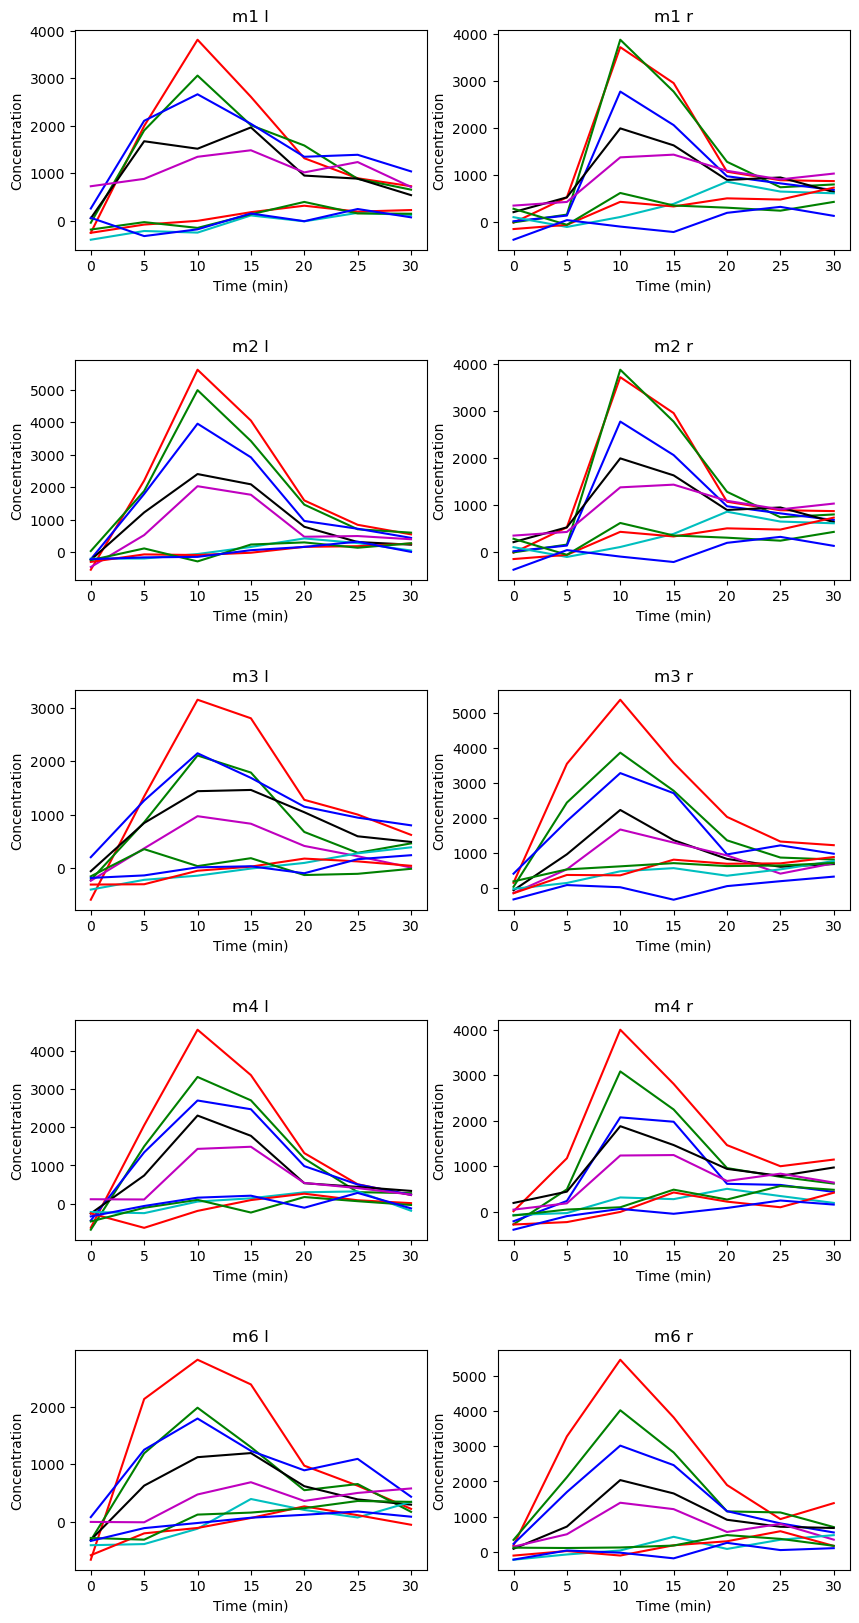

In [154]:
#idx = 2
#plot_time_series(times_list[idx], locations_list[idx], real_data_list[idx], plot_legend=True)

# create a 5 by 2 plot
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    for j in range(2):
        idx = i*2 + j
        plt.sca(axs[i, j])
        plot_time_series(times_list[idx], locations_list[idx], real_data_list[idx], plot_legend=False)
        axs[i, j].set_title(f'{args_list[idx].animal} {args_list[idx].ear}')

# Add vertical space between subplots
plt.subplots_adjust(hspace=0.5)

#### Extract data points from which the noise level is to be estimated.

The data points below the red line in the plot are used to estimate the noise level. For those data points, the true concentration is assumed to be zero.

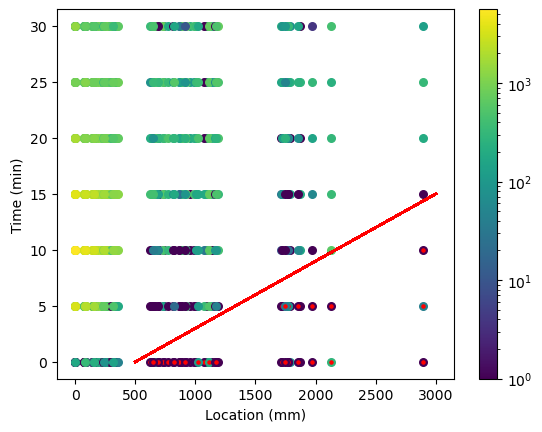

In [155]:
# plot all concentration data in 2D image (location/time) colored by concentration
data_for_noise_estimation = []
std_data_for_noise_estimation = []
data_for_noise_estimation_per_case = []
std_data_for_noise_estimation_per_case = []
for i, case in enumerate(cases_list):
    data_for_noise_estimation_per_case.append([])
    std_data_for_noise_estimation_per_case.append([])
    for j, loc in enumerate(locations_list[i]):
        for k, t in enumerate(times_list[i]/60):
            orig_data = real_data_list[i][j, k]
            orig_std_data = real_std_data_list[i][j, k]
            clipped_data = np.clip(orig_data, 1, max_concentration)
            plt.scatter(loc, t, c=clipped_data, s=30, norm=matplotlib.colors.LogNorm(vmin=1, vmax=max_concentration))
            # if data below line (500, 0) to (3000, 15), add to noise estimation
            line_eq = lambda loc_x:  15/2500*(loc_x-500)
            # draw line
            plt.plot([500, 3000], [line_eq(500), line_eq(3000)], 'r')
            if t < line_eq(loc):
                plt.scatter(loc, t, c='r', s=5)
                data_for_noise_estimation_per_case[i].append(orig_data)
                std_data_for_noise_estimation_per_case[i].append(orig_std_data)
                data_for_noise_estimation.append(orig_data)
                std_data_for_noise_estimation.append(orig_std_data)

plt.colorbar()
plt.xlabel('Location (mm)')
plt.ylabel('Time (min)')

#convert to numpy array
data_for_noise_estimation = np.array(data_for_noise_estimation)
std_data_for_noise_estimation = np.array(std_data_for_noise_estimation)




#### Compute noise estimate in concentration data
Consider the data points below the red line. Each data point j for case i ($c_i^j$), is an average of 9 voxels. It has an associated standard deviation ($\sigma_i^j$).

$$\sigma_i^j = \sqrt{\frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j - c_i^j)^2}$$

and we can write

$$ \left(\sigma_i^j\right)^2 =\frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j - c_i^j)^2$$

where $c_{i,k}^j$ is the concentration of voxel k used in estimating data point j for case i.

The noise STD for case i can be computed as

$$\sigma_i^2 = \frac{1}{n} \sum_{j=1}^n \frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j - \bar{c}_{i})^2$$

where $n$ is the number of data points below the red line for case i, and $\bar{c}_{i}$ is the average of all the $9*n$ voxel data points for case i.

Assume $\bar{c}_{i} \approx c_i^j$ for each data point j. We can write

$$\sigma_i^2 = \frac{1}{n} \sum_{j=1}^n \frac{1}{9} \sum_{k=1}^9 (c_{i,k}^j -  c_i^j)^2$$

and thus the noise variance $\sigma_i^2$ for case i is approximated by

$$\sigma_i^2 = \frac{1}{n} \sum_{j=1}^n \left(\sigma_i^j\right)^2 $$

**Note:** we might need to consider dividing by 9-1 instead of 9 to compute the noise variance $\left(\sigma_i^j\right)^2$ and by $n*9-1$ instead of $n*9$ to compute the noise variance $\sigma_i^2$.

In [156]:
# Noise std estimation
noise_std = np.sqrt(np.average(std_data_for_noise_estimation**2))
print("Noise std: ", noise_std)
noise_std_per_case_list = []

# Noise std estimation per case
for i, case in enumerate(cases_list):
    noise_std_per_case = np.sqrt(np.average(np.array(std_data_for_noise_estimation_per_case[i])**2))
    print(f"Noise std (sigma_i) for case i={i}", case, ": ", noise_std_per_case)
    noise_std_per_case_list.append(noise_std_per_case)


Noise std:  292.89441389182974
Noise std (sigma_i) for case i=0 ('m1', 'l') :  284.32061209803277
Noise std (sigma_i) for case i=1 ('m1', 'r') :  280.34568790691253
Noise std (sigma_i) for case i=2 ('m2', 'l') :  312.771102205111
Noise std (sigma_i) for case i=3 ('m2', 'r') :  291.47625867763963
Noise std (sigma_i) for case i=4 ('m3', 'l') :  312.493149497393
Noise std (sigma_i) for case i=5 ('m3', 'r') :  367.29030905674597
Noise std (sigma_i) for case i=6 ('m4', 'l') :  242.5273744681206
Noise std (sigma_i) for case i=7 ('m4', 'r') :  289.5633196749892
Noise std (sigma_i) for case i=8 ('m6', 'l') :  271.59213783097624
Noise std (sigma_i) for case i=9 ('m6', 'r') :  258.85113263959266


#### Compute noise estimate in gradient data

The gradient data is computed as the difference between the concentration of adjacent data points j and j+1 for time t divided by the distance between the two data points. The noise variance of the difference is the sum of the variances of the two data points, and taking the distance into account, we can write

$$\sigma_{\nabla c}^2 = \frac{\sigma_{c}^2 + \sigma_{c}^2}{\Delta x^2}$$

where $\sigma_{c}^2$ is the noise variance in concentration data.

In [157]:
# Noise estimation in data gradient
grad_data_std = np.sqrt(2)*noise_std
print("Grad data std: ", grad_data_std)
print("this value need to be devided by location difference")
print()

# Noise estimation in data gradient per case
for i, case in enumerate(cases_list):
    grad_data_std_per_case = np.sqrt(2)*noise_std_per_case_list[i]
    print("Grad data std for case ", case, ": ", grad_data_std_per_case)
    print("Note: this value need to be divided by location difference")
    print()

Grad data std:  414.21525246914433
this value need to be devided by location difference

Grad data std for case  ('m1', 'l') :  402.09006569125785
Note: this value need to be divided by location difference

Grad data std for case  ('m1', 'r') :  396.4686739907707
Note: this value need to be divided by location difference

Grad data std for case  ('m2', 'l') :  442.32513465684946
Note: this value need to be divided by location difference

Grad data std for case  ('m2', 'r') :  412.20967813168653
Note: this value need to be divided by location difference

Grad data std for case  ('m3', 'l') :  441.93205016789636
Note: this value need to be divided by location difference

Grad data std for case  ('m3', 'r') :  519.4269363962558
Note: this value need to be divided by location difference

Grad data std for case  ('m4', 'l') :  342.98550221955446
Note: this value need to be divided by location difference

Grad data std for case  ('m4', 'r') :  409.50437385014584
Note: this value need to be d

#### Just for illustration, plot the data points used to estimate the noise level

avg:  -163.25957604395606
max:  281.3121714285714
min:  -580.375


Text(0, 0.5, 'Data value')

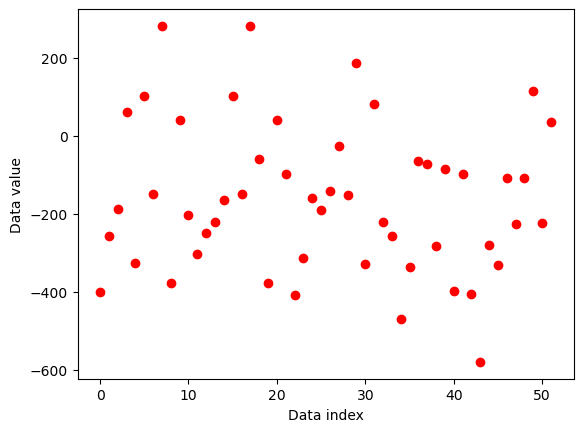

In [158]:
print("avg: ", np.average(data_for_noise_estimation))
print("max: ", np.max(data_for_noise_estimation))
print("min: ", np.min(data_for_noise_estimation))
plt.plot(data_for_noise_estimation, 'ro')
plt.xlabel('Data index')
plt.ylabel('Data value')